# Feature engineering with Pandas

## Импорты 

In [5]:
import yaml

with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
# from xgboost import XGBRegressor

### Общая информация

In [8]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'  
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
cfg = {
    'house_pricing': {
        'test_dataset': 'kaggle_house_prices.tar/train.csv'  
    }
}
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Не все столбцы здесь выведены. Их список мы можем получить, используя аттрибут `columns`:

In [11]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Почистим данные в нескольких столбцах, основываясь на data_description

In [12]:
train_df["Exterior2nd"] = train_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].where(train_df.GarageYrBlt <= 2010, train_df.YearBuilt)
    # Names beginning with numbers are awkward to work with
train_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [13]:
cat_df = train_df.select_dtypes(include=['object'])

In [14]:
num_df = train_df.select_dtypes(exclude=['object'])


## Коррелирующие признаки

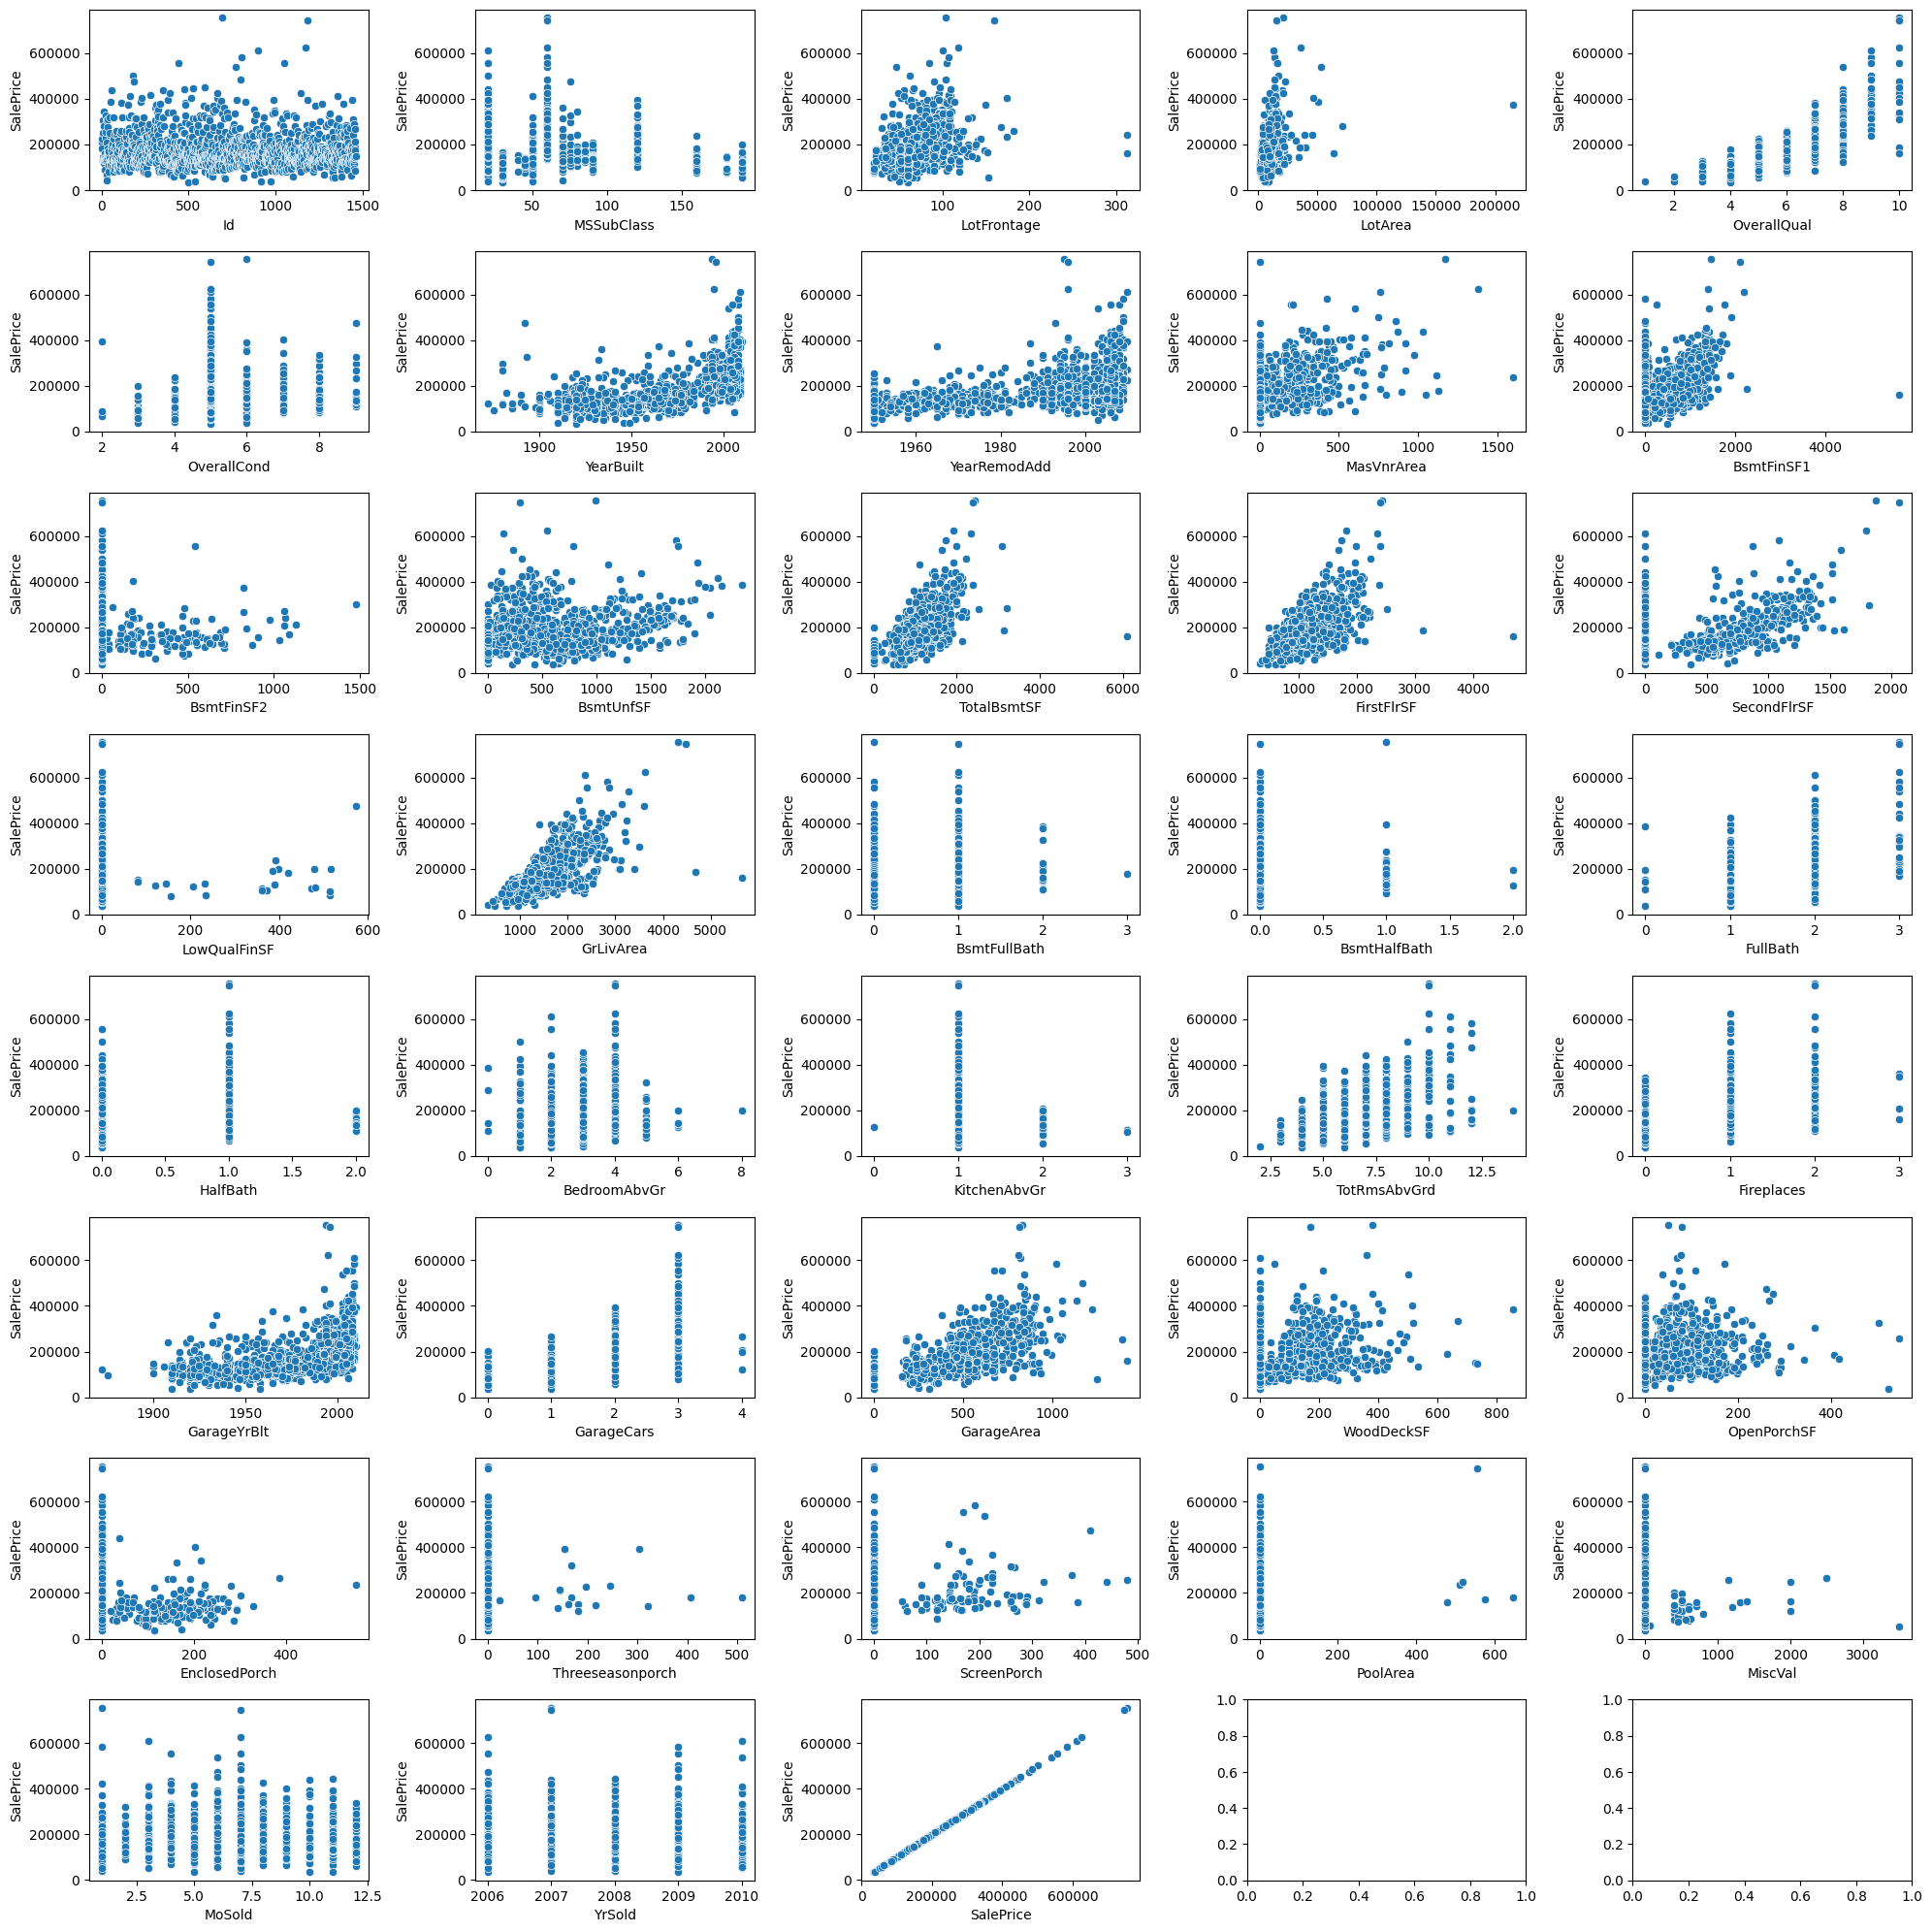

In [15]:
fig, axes = plt.subplots(8, 5, figsize=(20, 20))
axes_flattened = axes.reshape(-1)
for i in range(len(num_df.columns)):
    ax = axes_flattened[i]
    sns.scatterplot(
        x=num_df.iloc[:, i],
        y='SalePrice',
        data=num_df.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

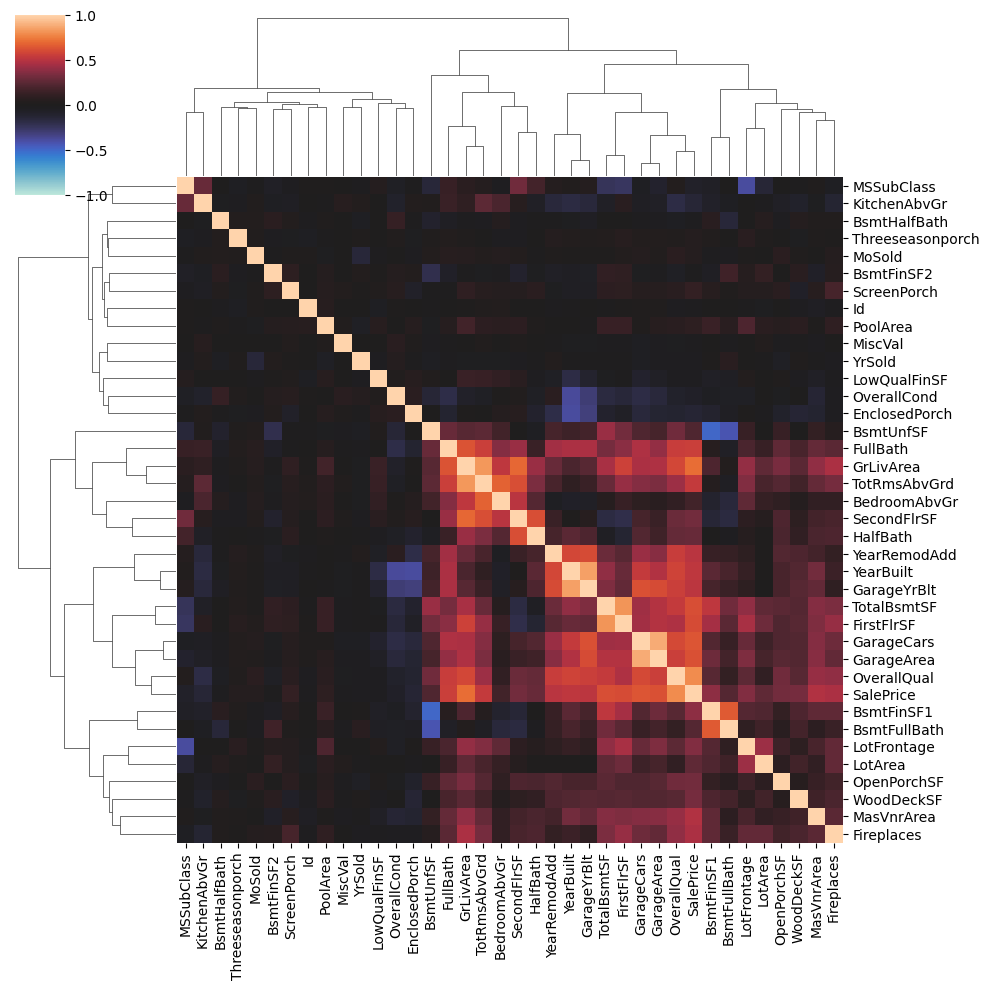

In [12]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(num_df, annot=None)

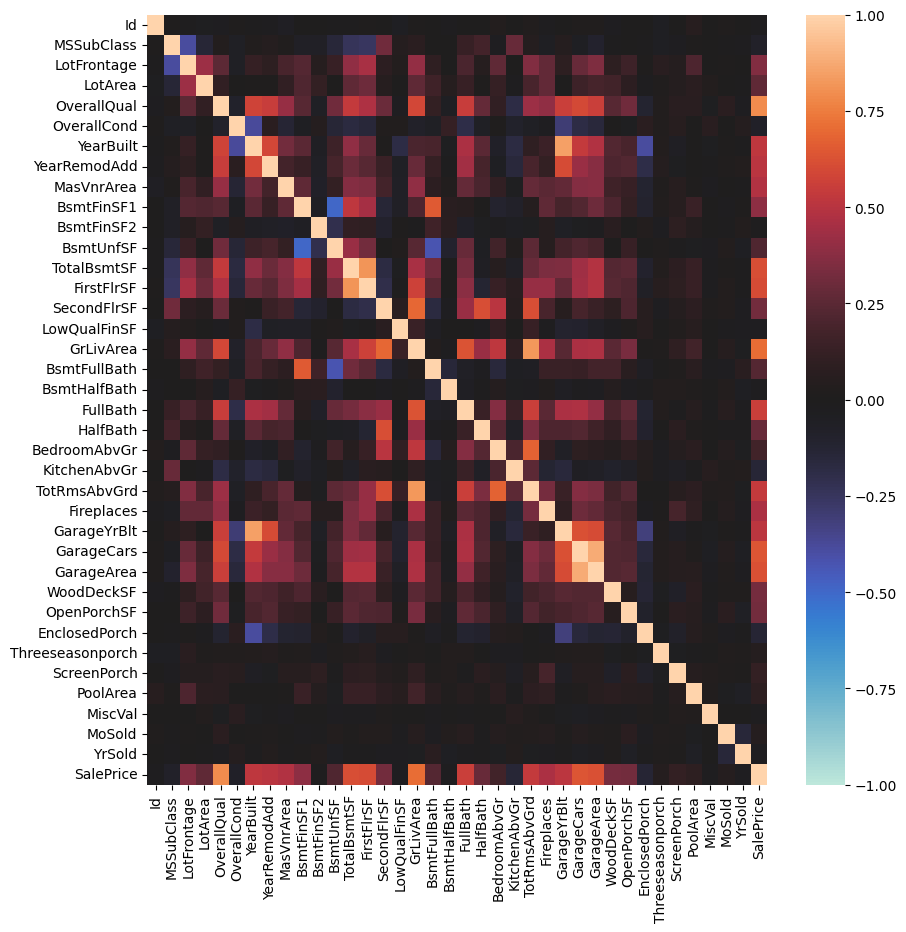

In [16]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        annot=annot,
        ax=ax,
        **kwargs,
    )


corrplot(num_df, annot=None)

Из этой матрицы можно увидеть, какие столбцы сильно коррелируют между собой, например:
1. GarageYrBlt и YearBuilt
2. TotRmsAbvGrd и GrLivArea
3. FirstFlrSF и TotalBsmtSF
4. GarageArea и GarageCars

**Задание**: Выведите 5 пар наиболее сильно коррелирующих признаков. Сколько пар признаков коррелирует больше, чем на 0.75?


In [17]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'  
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

corr_matrix = df_numeric.corr().abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

corr_pairs = upper_triangle.stack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

top_correlations = corr_pairs[corr_pairs['Correlation'] > 0].sort_values(
    by='Correlation', ascending=False).head(5)

strong_corr_count = corr_pairs[corr_pairs['Correlation'] > 0.75].shape[0]


print("Топ-5 наиболее коррелирующих пар признаков:")
print(top_correlations.to_string(index=False))

print(f"\nКоличество пар признаков с корреляцией > 0.75: {strong_corr_count}")

Топ-5 наиболее коррелирующих пар признаков:
   Feature1     Feature2  Correlation
 GarageCars   GarageArea     0.882475
  YearBuilt  GarageYrBlt     0.825667
  GrLivArea TotRmsAbvGrd     0.825489
TotalBsmtSF     1stFlrSF     0.819530
OverallQual    SalePrice     0.790982

Количество пар признаков с корреляцией > 0.75: 5


**Задание**: Постройте карту корреляций, но не используя clustermap. Используйте для этого heatmap. Ответьте на вопрос, те же пары признаков наиболее ярко подсвечены или разные? По какому из графиков вам удобнее делать выводы?

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Карта корреляций (pearson)'}>)

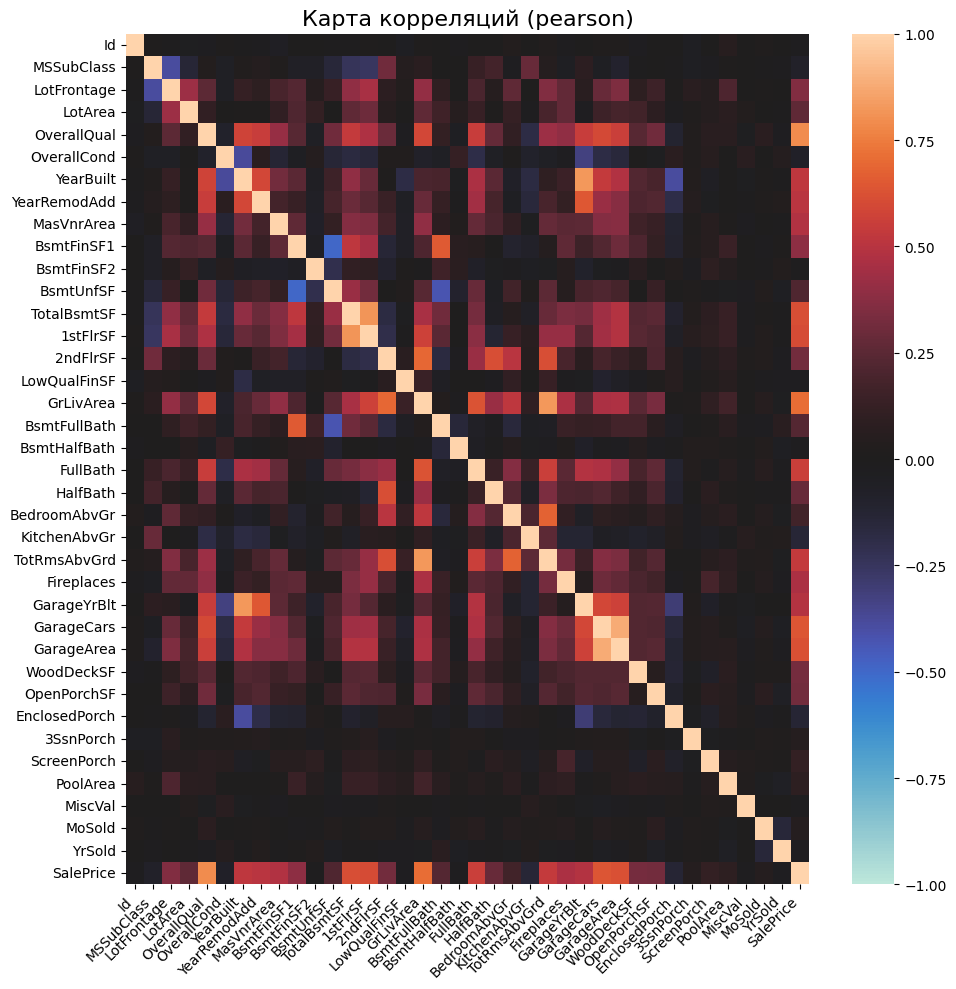

<Figure size 640x480 with 0 Axes>

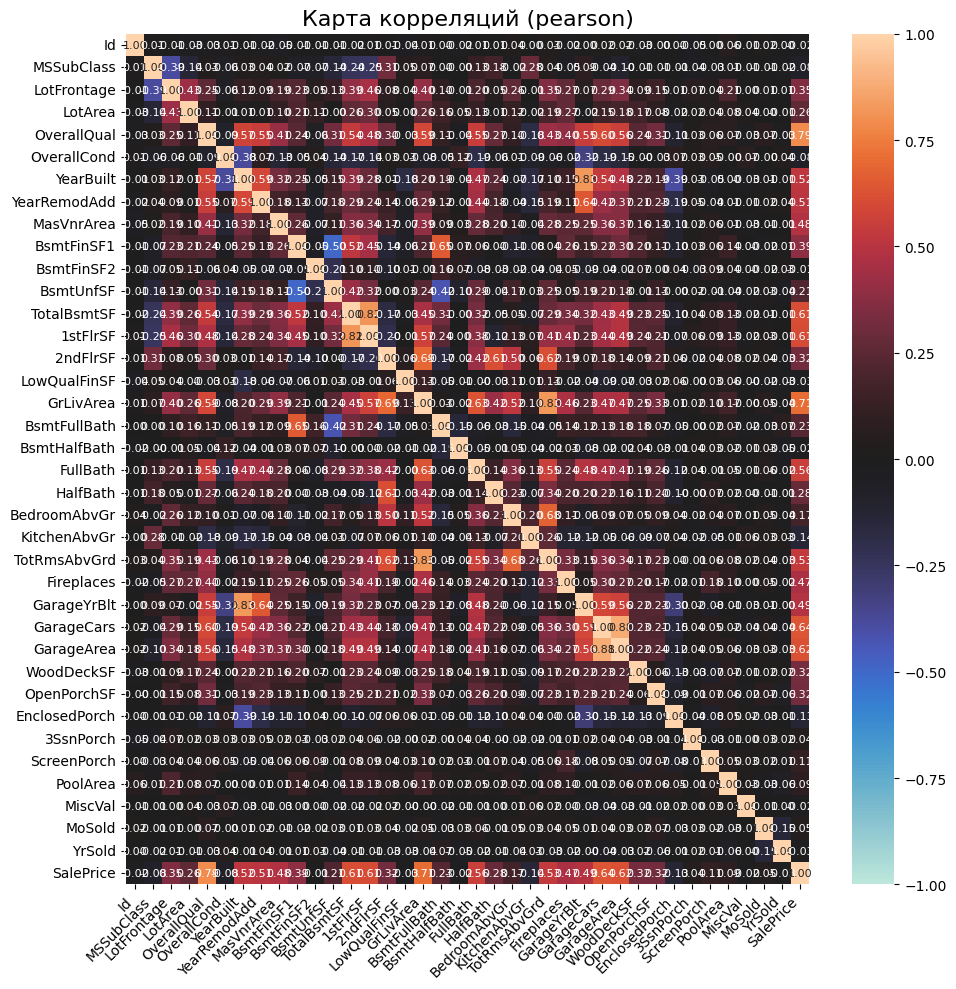

In [19]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'  
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

num_df = df.select_dtypes(include=[np.number])

def corrplot(df, method="pearson", annot=True, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        annot=annot,
        ax=ax,
        **kwargs,
    )
    plt.title(f'Карта корреляций ({method})', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    return fig, ax

corrplot(num_df, annot=None)

plt.figure()
corrplot(num_df, annot=True, fmt=".2f", annot_kws={"size": 8})

**Задание**: Выбросьте несколько лишних признаков из датасета.

In [20]:
train_df.drop(
    ['GarageYrBlt','TotRmsAbvGrd','FirstFlrSF','GarageCars'],
    axis=1,
    inplace=True
)

## Заполнение пустых значений

Может быть множество вариантов, при которых строка может содержать пустые значения. Например:
1. Дом с 2 спальнями не может включать ответ на вопрос, насколько велика третья спальня
2. Кто-то из опрошенных может не делиться своим доходом
3. ...
   
Библиотеки Python представляют недостающие числа как NaN-ми, что является сокращением от "not a number".

Соберем статистику, связанную с NaN-ми. Какие ячейки имеют недостающие значения (в процентах), можно определить с помощью команды:

In [23]:
nan_df = (train_df.isnull().mean() * 100).reset_index()
nan_df

,index,0
0,Id,0.000000
1,MSSubClass,0.000000
2,MSZoning,0.000000
3,LotFrontage,17.739726
4,LotArea,0.000000
...,...,...
72,MoSold,0.000000
73,YrSold,0.000000
74,SaleType,0.000000
75,SaleCondition,0.000000


Преобразуем этот датафрейм в более изящный вид:

In [24]:
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
68,PoolQC,99.520548
70,MiscFeature,96.301370
6,Alley,93.767123
69,Fence,80.753425
25,MasVnrType,59.726027
55,FireplaceQu,47.260274
3,LotFrontage,17.739726
56,GarageType,5.547945
57,GarageFinish,5.547945
59,GarageQual,5.547945


In [25]:
test_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Выведем квантили:

In [26]:
intro_srt = "Number of columns with more than"
for percent in (80, 50, 20, 5):
    print(f"{intro_srt} {percent}% NANs: {(nan_df.percentage > percent).sum()}")

Number of columns with more than 80% NANs: 4
Number of columns with more than 50% NANs: 5
Number of columns with more than 20% NANs: 6
Number of columns with more than 5% NANs: 11


Выведем столбцы с более чем 80% NaN-в

In [27]:
nan_columns = list(nan_df[nan_df.percentage > 80]['column_name'])
nan_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

Большинство моделей не умеют работать с NaN-ми. Поэтому требуется избавиться от них.
Вообще есть три вида отсутствия значений: Полностью случайное, случайное и неслучайное. 
- Полностью случайное не связано ни с какими другими зависимостями в датасете. Удаление таких данных никак не повлияет на результаты.
- Случайное связано с наблюдаемыми переменными, но не с ненаблюдаемыми. Это самый широкий класс, и с ним борется большинство методов.
- Случайное, которое связано с ненаблюдаемыми переменными (например, старением оборудования).
В зависимости от того, с каким видом пропусков мы имеем дело, можно использовать разные методы.

### Выброс стоблцов с NaN-ми

In [28]:
# 1 вариант - если, например, нужно выбросить одинаковые 
# столбцы для обучающей и тестовой выборок
num_сols_with_missing = [col for col in num_df.columns 
                         if num_df[col].isnull().any()]
num_сols_with_missing

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [29]:
print(len(num_df.columns))
num_df_dropped = num_df.drop(num_сols_with_missing, axis=1)
print(len(num_df_dropped.columns))

38
35


**2 опция:** выбросить столбцы, напрямую используя `dropna()`

In [30]:
print(len(num_df.columns))
num_df_dropped = num_df.dropna(axis=1)
print(len(num_df_dropped.columns))

38
35


Если эти столбцы содержат полезную информацию (в местах, которые не были пропущены), модель теряет доступ к этой информации при удалении столбца. Кроме того, если тестовые данные имеют отсутствующие значения в тех местах, где тренировочные не имели, это приведет к ошибке.
Однако оно может быть полезно, когда большинство значений в столбце отсутствуют. 

**Задание**: выбросьте столбцы, у которых отсутствует больше 75% значений.  Сделайе это и для тренировочных, и для тестовых данных

In [ ]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv',
        'test_dataset': 'kaggle_house_prices.tar/test.csv'
    }
}

train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])

def drop_high_missing_columns(df, threshold=0.75):
    missing_ratio = df.isna().mean()

    cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()

    df_dropped = df.drop(columns=cols_to_drop)
    
    return df_dropped, cols_to_drop

train_df_cleaned, train_dropped_cols = drop_high_missing_columns(train_df, threshold=0.75)

test_df_cleaned, test_dropped_cols = drop_high_missing_columns(test_df, threshold=0.75)

print("Для тренировочных данных:")
print(f"Удалено столбцов: {len(train_dropped_cols)}")
print(f"Список удаленных столбцов: {train_dropped_cols}")
print(f"Осталось столбцов: {train_df_cleaned.shape[1]}")
print("\nДля тестовых данных:")
print(f"Удалено столбцов: {len(test_dropped_cols)}")
print(f"Список удаленных столбцов: {test_dropped_cols}")
print(f"Осталось столбцов: {test_df_cleaned.shape[1]}")

# Сохранение обработанных данных (опционально)
train_df_cleaned.to_csv('train_cleaned.csv', index=False)
test_df_cleaned.to_csv('test_cleaned.csv', index=False)

Для тренировочных данных:
Удалено столбцов: 4
Список удаленных столбцов: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
Осталось столбцов: 77

Для тестовых данных:
Удалено столбцов: 4
Список удаленных столбцов: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
Осталось столбцов: 76


### Заполнение недостающих значений каким-то значением

Это значение будет не совсем правильным в большинстве случаев, но обычно оно дает более точные модели, чем полное удаление столбца.

**Числовые признаки**

Поведение по умолчанию заполняет столбец средним значением в заполненных ячейках. Существуют и более сложные стратегии.

In [32]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

filled_cols = my_imputer.fit_transform(train_df[num_сols_with_missing])

In [33]:
filled_cols

array([[  65.,  196., 2003.],
       [  80.,    0., 1976.],
       [  68.,  162., 2001.],
       ...,
       [  66.,    0., 1941.],
       [  68.,    0., 1950.],
       [  75.,    0., 1965.]])

Альтернативно можно заполнить столбцы средним напрямую (или нулями, или чем угодно)

С точки зрения статистики такое заполнение оправдано, если все между признаками нет явной зависимости. В таком случае замена пропусков средними значениями не вносит смещения. Однако, часто условие независимости нарушается.

Взглянем на распределения средних значений по районам.

<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

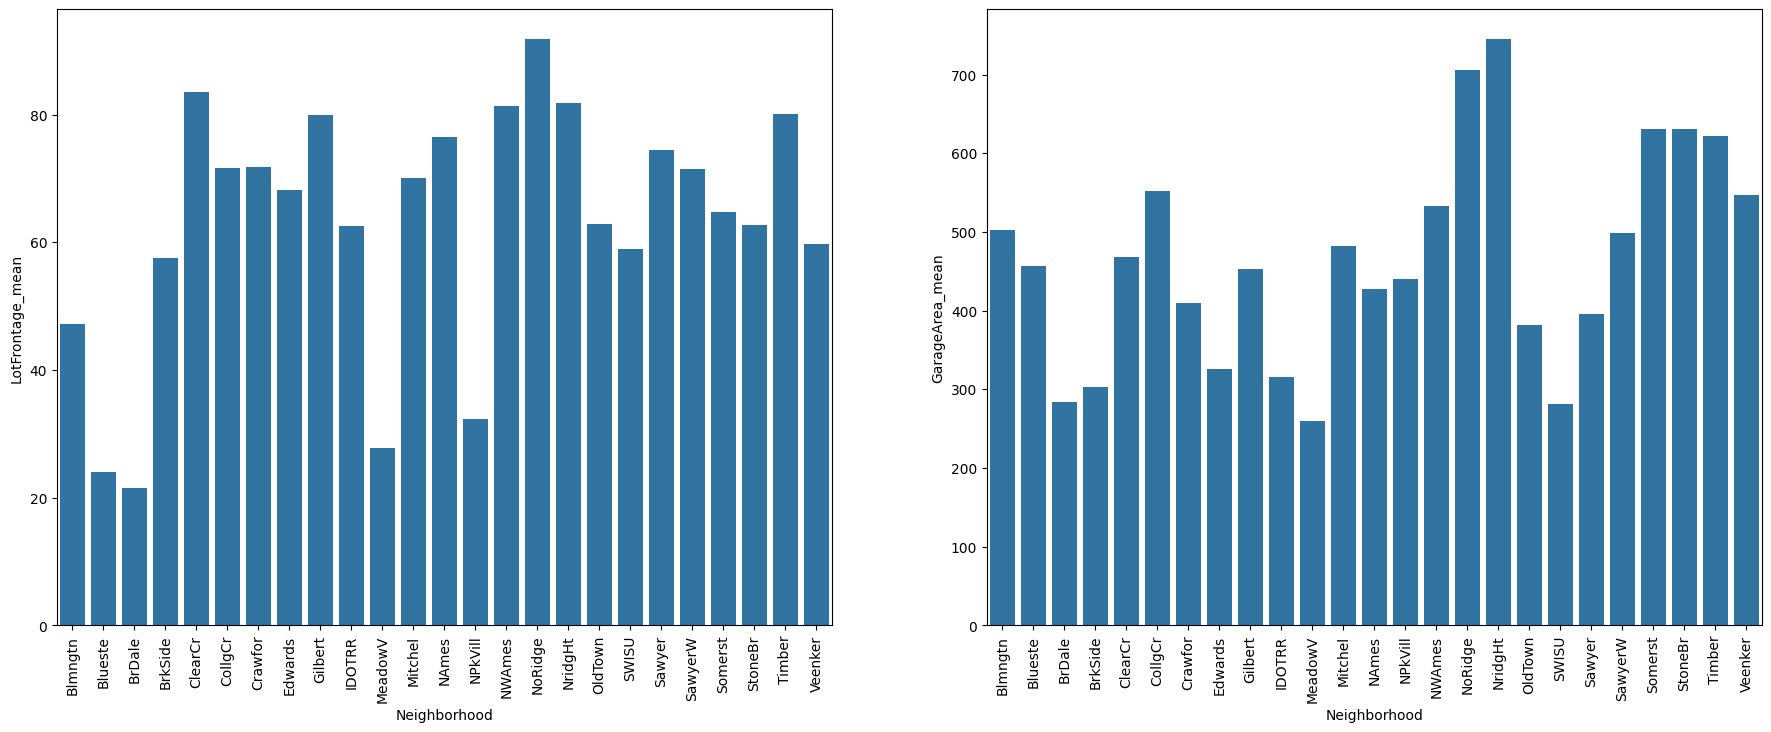

In [34]:
neigh_grouped = train_df.groupby('Neighborhood')
neigh_lot = (
    neigh_grouped['LotFrontage'].mean()
    .reset_index(name='LotFrontage_mean')
)
neigh_garage = (
    neigh_grouped['GarageArea'].mean()
    .reset_index(name='GarageArea_mean')
)

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

В данном примере свойства домов сильно зависят от того, в каком районе они расположены. Поэтому средние значения лучше считать по районам. Это будет простой вариант построения модели для заполнения значений. Вы также можете строить линейные модели или любые другие. 

In [35]:
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
train_df['GarageArea'] = train_df.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))

Заполним все оставшиеся числовые признаки средними (ранее мы не сохраняли результат в `train_df`)

In [36]:
train_df[num_сols_with_missing] = train_df[num_сols_with_missing].fillna(train_df[num_сols_with_missing].mean())

Те столбцы, которые содержали более 80% NANов, удалим совсем

In [37]:
train_df.drop(nan_columns, inplace=True, axis=1)

**Категориальные (номинальные) признаки**

Для заполнения категориапльных признаков естественно использовать значение по умолчанию "NA" или "missing". 


Понятие среднего здесь тяжело использовать, поэтому проще заполнить модой, то есть наиболее часто встречающимся значением. 

In [38]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [39]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
for col in cols:
    print(f"Mode of column {col} is {train_df[col].dropna().mode()[0]}")
train_df[cols] = train_df.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.dropna().mode()[0]))

Mode of column MasVnrType is BrkFace
Mode of column MSZoning is RL
Mode of column Exterior1st is VinylSd
Mode of column Exterior2nd is VinylSd
Mode of column SaleType is WD
Mode of column Electrical is SBrkr
Mode of column Functional is Typ


KeyError: 0

**Порядковые признаки**

Значение "NA" удобно ассоциировать с нулем. Но такая замена меняет число уровней у признака, что может быть нежелательно. Более того, часто неочевидно, какой уровень признака соответствует NA.

In [40]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']
train_df[cat] = train_df[cat].fillna("NA")

Одним из основных недостатков простого заполнения является то, что оно может привести к невозможным конфигурациям в данных. Представьте, что гараж отсутствует, но мы знаем число мест для машин. И хотя это неверно с точки зрения логики, это может быть все раыдно улучшением отсносительно ситуации, когда модель вообще не работала на прмиере с пропуском.

**Задание**: Используя simple imputer или заполнение модой на исходных тренировочных данных (вероятно, копии), создайте и найдите невозможную комбинацию (комбинации) в данных. Покажите пример(ы).

In [44]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

train_filled = train_df.copy()

basement_garage_cat = [
    'GarageType', 'GarageFinish', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 
    'GarageCond', 'GarageQual', 'BsmtCond', 'BsmtQual', 'FireplaceQu', "KitchenQual",
    "HeatingQC", 'ExterQual', 'ExterCond'
]

train_filled[basement_garage_cat] = train_filled[basement_garage_cat].fillna("NA")

cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]

for col in cols:
    mode_per_neighborhood = train_filled.groupby("Neighborhood")[col].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    train_filled[col] = train_filled[col].fillna(mode_per_neighborhood)

impossible_combinations = []

garage_condition = (
    (train_filled['GarageType'] == "NA") &
    (
        (train_filled['GarageYrBlt'].notna()) |
        (train_filled['GarageArea'] > 0) | 
        (train_filled['GarageCars'] > 0))
)
if garage_condition.any():
    print("Невозможная комбинация 1: Отсутствие гаража, но указаны его характеристики")
    impossible_combinations.append(("GarageType == 'NA'", "GarageYrBlt, GarageArea или GarageCars > 0"))
    display(train_filled[garage_condition][['GarageType', 'GarageYrBlt', 'GarageArea', 'GarageCars']].head())

basement_condition = (
    (train_filled['BsmtQual'] == "NA") &
    (
        (train_filled['TotalBsmtSF'] > 0) |
        (train_filled['BsmtFinSF1'] > 0) |
        (train_filled['BsmtUnfSF'] > 0)
    )
)
if basement_condition.any():
    print("\nНевозможная комбинация 2: Отсутствие подвала, но указаны его характеристики")
    impossible_combinations.append(("BsmtQual == 'NA'", "TotalBsmtSF, BsmtFinSF1 или BsmtUnfSF > 0"))
    display(train_filled[basement_condition][['BsmtQual', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtUnfSF']].head())

fireplace_condition = (
    (train_filled['FireplaceQu'] == "NA") &
    (train_filled['Fireplaces'] > 0)
)
if fireplace_condition.any():
    print("\nНевозможная комбинация 3: Отсутствие камина, но указано их количество")
    impossible_combinations.append(("FireplaceQu == 'NA'", "Fireplaces > 0"))
    display(train_filled[fireplace_condition][['FireplaceQu', 'Fireplaces']].head())

pool_condition = (
    (train_filled['PoolArea'] == 0) &
    (train_filled['PoolQC'].notna())
)
if pool_condition.any():
    print("\nНевозможная комбинация 4: Отсутствие бассейна, но указано его качество")
    impossible_combinations.append(("PoolArea == 0", "PoolQC не NA"))
    display(train_filled[pool_condition][['PoolArea', 'PoolQC']].head())

remodel_condition = (
    (train_filled['YearRemodAdd'] < train_filled['YearBuilt']) & 
    (train_filled['YearRemodAdd'] != train_filled['YearBuilt'])
)
if remodel_condition.any():
    print("\nНевозможная комбинация 5: Год ремонта раньше года постройки")
    impossible_combinations.append(("YearRemodAdd < YearBuilt", "Год ремонта не может быть раньше года постройки"))
    display(train_filled[remodel_condition][['YearBuilt', 'YearRemodAdd']].head())

area_condition = (
    (train_filled['GrLivArea'] > train_filled['LotArea'])
)
if area_condition.any():
    print("\nНевозможная комбинация 6: Жилая площадь больше площади участка")
    impossible_combinations.append(("GrLivArea > LotArea", "Жилая площадь не может быть больше площади участка"))
    display(train_filled[area_condition][['GrLivArea', 'LotArea']].head())

if impossible_combinations:
    print("\nОбнаружены следующие невозможные комбинации:")
    for i, (condition, description) in enumerate(impossible_combinations, 1):
        print(f"{i}. {condition} -> {description}")
else:
    print("Невозможные комбинации не обнаружены")

Невозможные комбинации не обнаружены


Другой минус константного заполнения - уменьшение дисперсии в данных, изменение распределения. Это происходит, так как мы добавляем много примеров с нулевой дисперсией. В том числе и поэтому полезно смотреть на зависмимость признака от других переменных.

**Задание**: Возьмите любой числовой столбец с достаточно хорошим распределением (в идеале, чтобы у гистограммы было несколько "горбов". МОжете сгенерировать или взять из данных. Выбросьте из него 10, 20, 50 и 70% примеров. Покажите на графиках, как меняется гистограмма. 


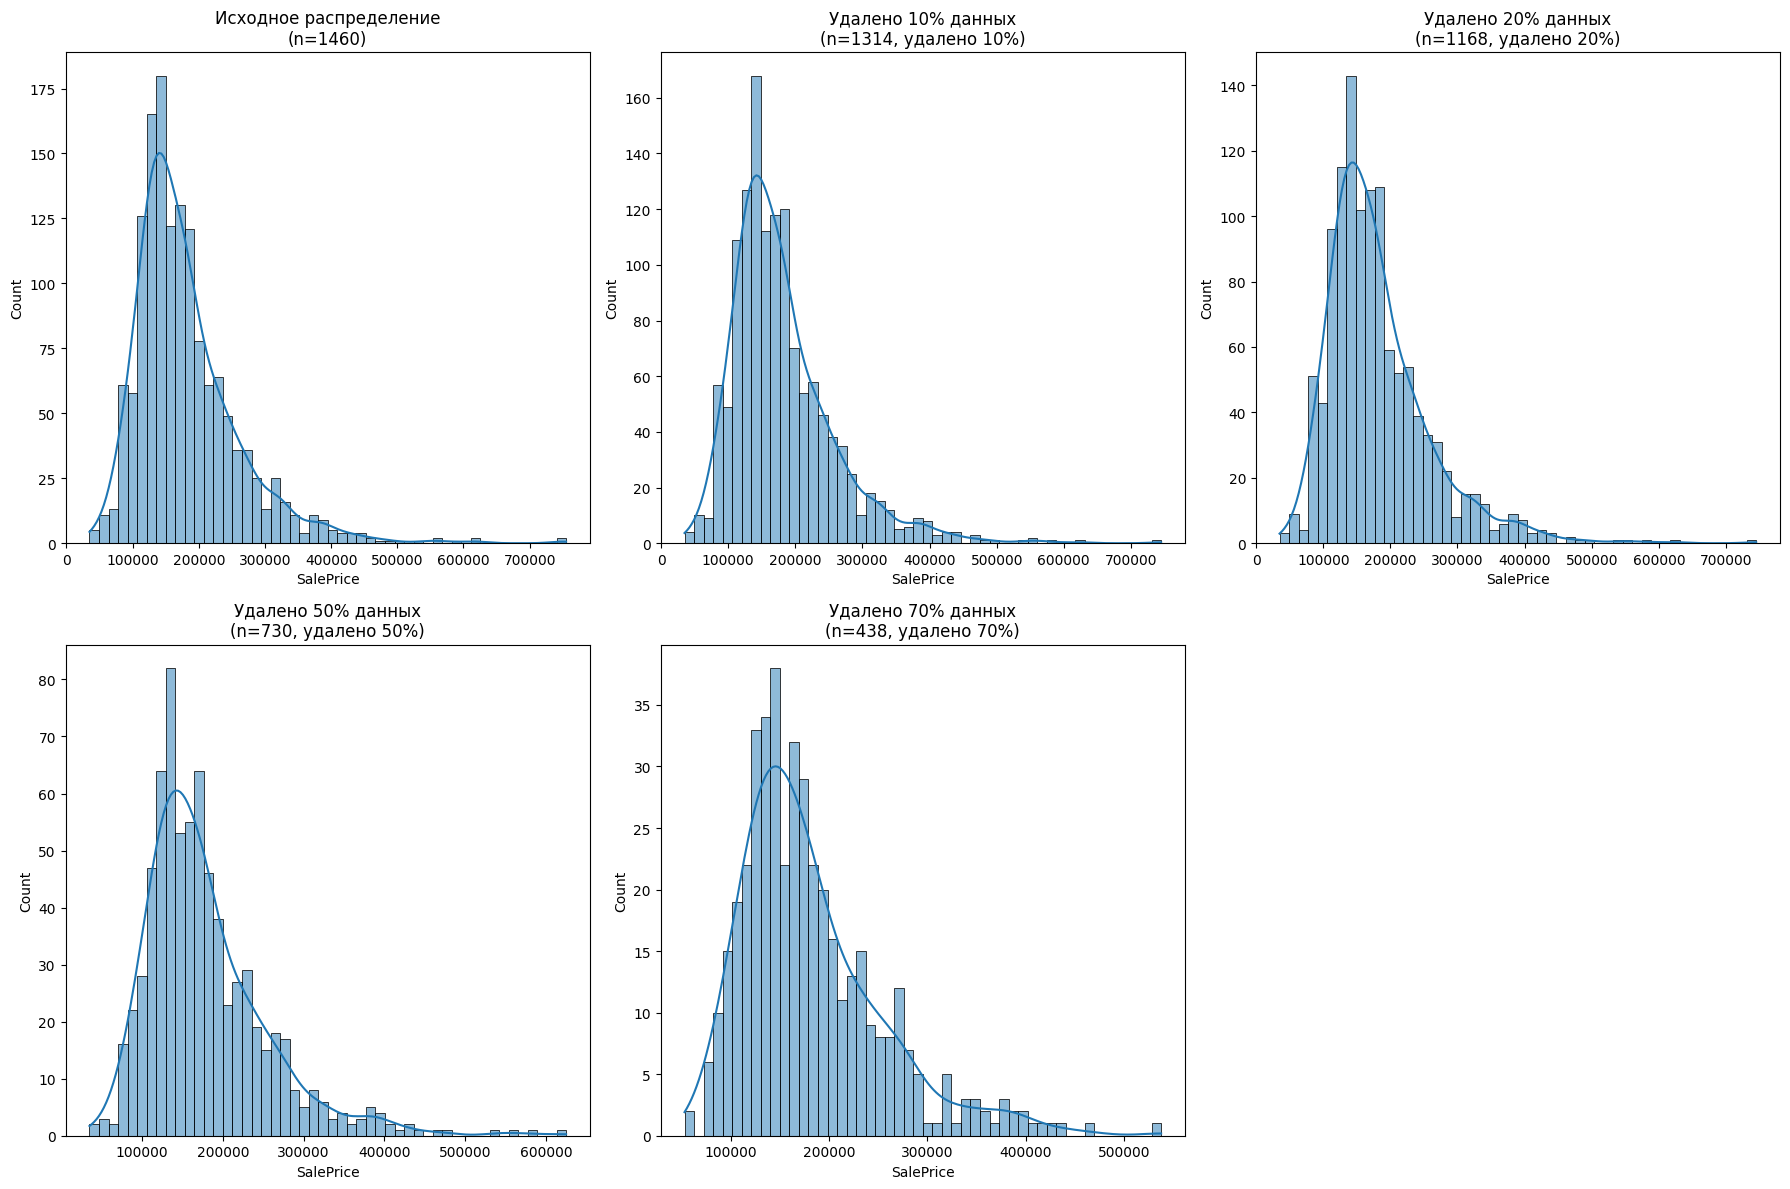

Влияние удаления данных на распределение:
Процент удаления | Среднее         | Стандартное отклонение | Коэффициент вариации
----------------------------------------------------------------------
0               | 180921.20       | 79442.50        | 43.91          %
10              | 181533.50       | 80102.69        | 44.13          %
20              | 179443.81       | 77941.89        | 43.44          %
50              | 183496.62       | 87986.08        | 47.95          %
70              | 183462.85       | 88971.51        | 48.50          %


In [45]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])
data = df['SalePrice'].dropna()

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.histplot(data, kde=True, bins=50)
plt.title(f"Исходное распределение\n(n={len(data)})")
plt.xlabel("SalePrice")

def plot_missing_distribution(ax, data, missing_percent, title):
    n_to_remove = int(len(data) * missing_percent / 100)

    np.random.seed(42)
    mask = np.ones(len(data), dtype=bool)
    mask[np.random.choice(len(data), n_to_remove, replace=False)] = False
    filtered_data = data[mask]

    sns.histplot(filtered_data, kde=True, bins=50, ax=ax)
    ax.set_title(f"{title}\n(n={len(filtered_data)}, удалено {missing_percent}%)")
    ax.set_xlabel("SalePrice")

missing_percents = [10, 20, 50, 70]

for i, percent in enumerate(missing_percents, 2):
    plt.subplot(2, 3, i)
    plot_missing_distribution(plt.gca(), data, percent, f"Удалено {percent}% данных")

plt.tight_layout()
plt.show()

print("Влияние удаления данных на распределение:")
print(f"{'Процент удаления':<15} | {'Среднее':<15} | {'Стандартное отклонение':<15} | {'Коэффициент вариации':<15}")
print("-" * 70)

for percent in [0] + missing_percents:
    n_to_remove = int(len(data) * percent / 100)
    mask = np.ones(len(data), dtype=bool)
    mask[np.random.choice(len(data), n_to_remove, replace=False)] = False
    filtered_data = data[mask]
    
    mean = filtered_data.mean()
    std = filtered_data.std()
    cv = (std / mean) * 100 if mean != 0 else 0
    
    print(f"{percent:<15} | {mean:<15.2f} | {std:<15.2f} | {cv:<15.2f}%")

**Задание**: Попробуйте найти зависимость какой-нибудь категориальной переменной от других (от одного столбца). Заполните ее с учетом этой зависимости.

Количество пропусков в Electrical: 1


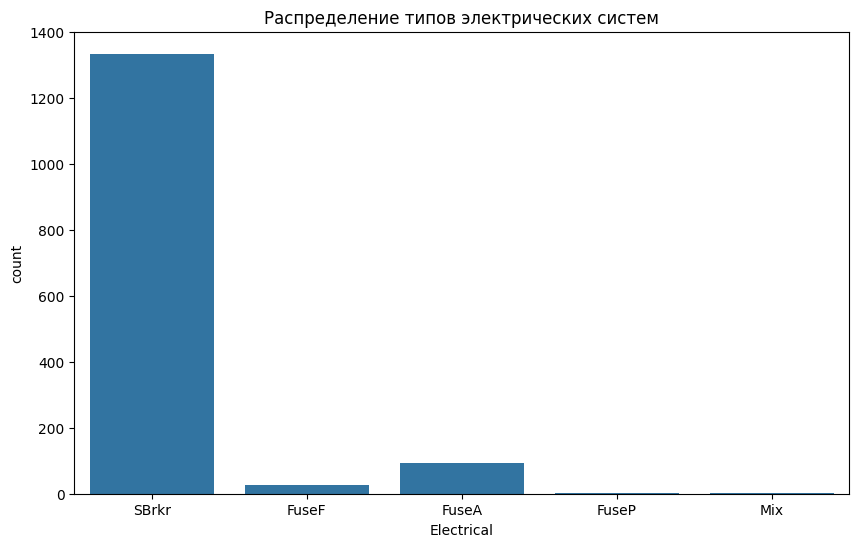

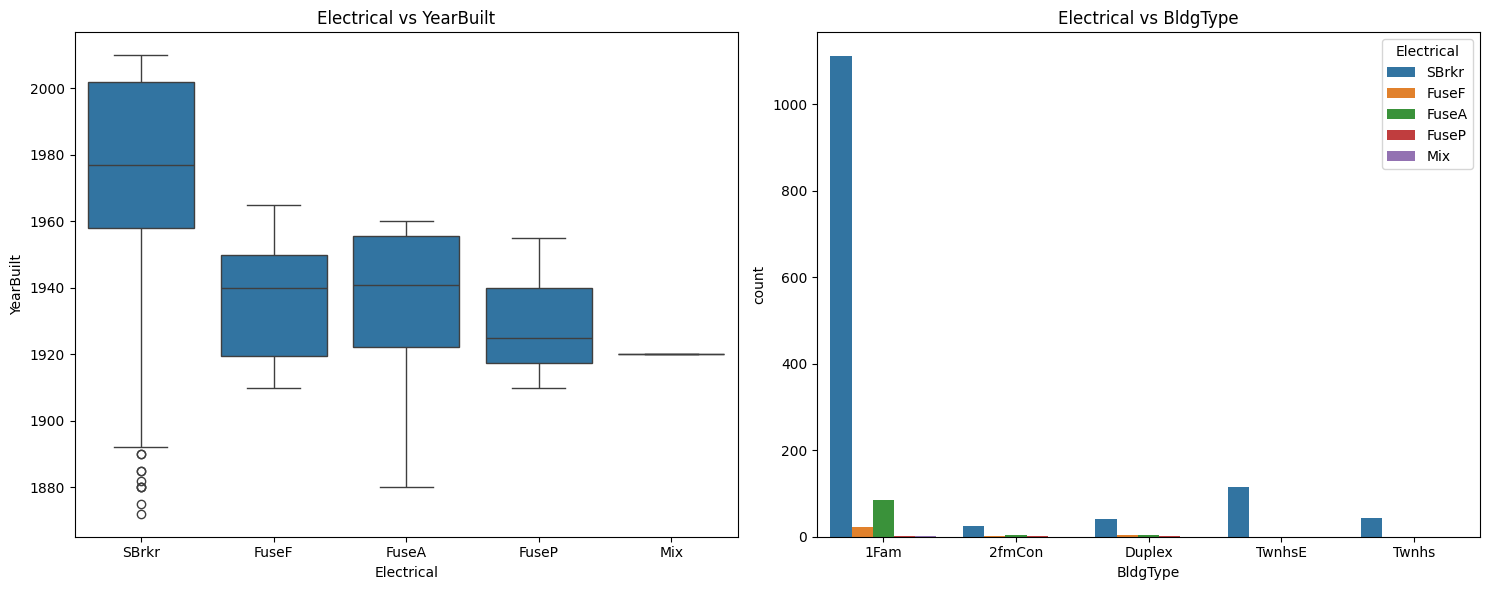

Строка с пропуском:
        Id  YearBuilt BldgType Electrical
1379  1380       2006     1Fam        NaN
Заполнение по YearBuilt и BldgType: SBrkr

Результат заполнения:
        Id  YearBuilt BldgType Electrical
1379  1380       2006     1Fam      SBrkr


In [47]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

print("Количество пропусков в Electrical:", df['Electrical'].isna().sum())

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Electrical')
plt.title('Распределение типов электрических систем')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=df, x='Electrical', y='YearBuilt', ax=axes[0])
axes[0].set_title('Electrical vs YearBuilt')

sns.countplot(data=df, x='BldgType', hue='Electrical', ax=axes[1])
axes[1].set_title('Electrical vs BldgType')
plt.tight_layout()
plt.show()

df_filled = df.copy()


missing_row = df_filled[df_filled['Electrical'].isna()]
print("Строка с пропуском:")
print(missing_row[['Id', 'YearBuilt', 'BldgType', 'Electrical']])

year_built = missing_row['YearBuilt'].values[0]
bldg_type = missing_row['BldgType'].values[0]

condition = (
    (df_filled['YearBuilt'] == year_built) & 
    (df_filled['BldgType'] == bldg_type)
)
if not df_filled[condition]['Electrical'].empty:
    mode_value = df_filled[condition]['Electrical'].mode()[0]
    print(f"Заполнение по YearBuilt и BldgType: {mode_value}")
    df_filled.loc[condition, 'Electrical'] = df_filled.loc[condition, 'Electrical'].fillna(mode_value)

elif not df_filled[df_filled['YearBuilt'] == year_built]['Electrical'].empty:
    mode_value = df_filled[df_filled['YearBuilt'] == year_built]['Electrical'].mode()[0]
    print(f"Заполнение только по YearBuilt: {mode_value}")
    df_filled.loc[df_filled['YearBuilt'] == year_built, 'Electrical'] = \
        df_filled.loc[df_filled['YearBuilt'] == year_built, 'Electrical'].fillna(mode_value)

else:
    mode_value = df_filled['Electrical'].mode()[0]
    print(f"Заполнение общей модой: {mode_value}")
    df_filled['Electrical'] = df_filled['Electrical'].fillna(mode_value)

print("\nРезультат заполнения:")
filled_row = df_filled.loc[missing_row.index]
print(filled_row[['Id', 'YearBuilt', 'BldgType', 'Electrical']])

## Удаление признаков со слабой вариативностью

**Признаки с одним типичным значением**

Некоторые признаки в основном состоят из одного значения или нулей, что не особо полезно для нас. Поэтому мы устанавливаем пороговое значение, определяемое пользователем, на уровне 96%. Если столбец имеет более 96% от одного и того же значения, мы считаем признак бесполезными и удалим его.

In [48]:
def get_almost_constant_columns(df, dropna=True):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 > 96:
            cols.append(i)
    return cols

In [49]:
cat_df = train_df.select_dtypes(include=['object'])
overfit_cat = get_almost_constant_columns(cat_df)
train_df = train_df.drop(overfit_cat, axis=1)
overfit_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [50]:
num_df = train_df.select_dtypes(exclude=['object'])
overfit_num = get_almost_constant_columns(num_df, dropna=True)
train_df = train_df.drop(overfit_num, axis=1)
overfit_num

['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']

Иногда слабая вариативность все же не означает, что признак бесполезен. Это возможно для очень сильно несбалансированной переменной с малым количеством уровней. Более того, иногда такая несбалансированность возникает и в таргете!

**Признаки с маленькой дисперсией**

Другой способ - использовать метод VarianceThreshold от sklearn — это простой базовый подход к выбору признаков. Он удаляет все признаки, дисперсия которых не соответствует определенному порогу. По умолчанию он удаляет все элементы с нулевой дисперсией, т.е. те элементы, которые имеют одинаковое значение у всех семплов.

Стоит отметить, что дисперсия является абсолютной величиной, и выбор порога в этом случае является эмпирическим. При этом в общем случае малые значения дисперсии не говорят о бесполезности признака. Если признак задан на поле вещественных чисел, то его дискриминирующая способность не зависит от дисперсии, так как любой непрерывный интервал на вещественной оси содержит бесконечный набор значений. Однако, в случае дискретных значений (пример, целочисленных признаков) VarianceThreshold действительно становится полезным

In [51]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)
num_col = train_df.select_dtypes(exclude=['object'])

sel.fit(num_col)  # fit finds the features with low variance
sum(sel.get_support())

32

Метод `get_support()` возвратит булевскую маску для признаков, которые проходят указанный порог по дисперсии. Ее можно использовать для отбора этих признаков 

In [52]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

Например, таким образом мы получаем список всех признаков, которые были отсеяны данным алгоритмом:

In [53]:
num_col.columns[~sel.get_support()]

Index(['BsmtHalfBath', 'KitchenAbvGr'], dtype='object')

## Удаление выбросов

Удаление выбросов предотвратит воздействие экстремальных значений на производительность наших моделей.

Из скаттерплотов выше мы можем увидеть, что следующие признаки имеют экстремальные выбросы:

* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

Мы уберем выбросы на основе определенного порогового значения.
Эти значения мы получим из боксплотов ("ящик с усиками"):

![Boxplot](boxplot.png)

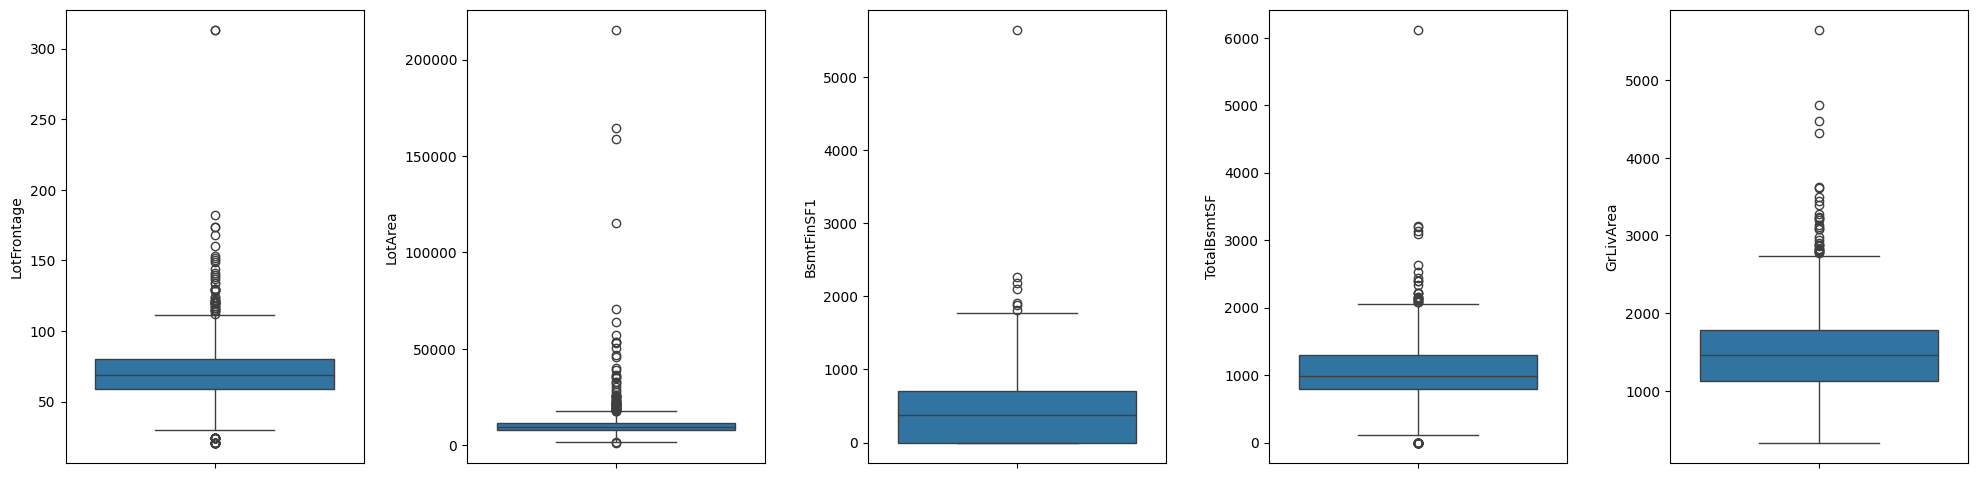

In [54]:
out_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=train_df[col], data=train_df, ax=ax)
fig.tight_layout(pad=1.5)

In [55]:
for col, upper_bound in (
    ('LotFrontage', 200),
    ('LotArea', 100000),
    ('BsmtFinSF1', 4000),
    ('TotalBsmtSF', 5000),
    ('GrLivArea', 4000),
):
    train_df = train_df.drop(train_df[train_df[col] > upper_bound].index)

После удаления выбросов, сильно коррелированных признаков и условных отсутствующих значений мы можем приступить к добавлению дополнительной информации для обучения нашей модели. Это делается с помощью - Feature Engineering.

**Задание**: Создайте копию данных. Удалите из числовых столбцов выбросы (используя интерквартильный размах)

In [56]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])
df_clean = df.copy()

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    mask = pd.Series([True] * len(df_clean))
    
    for col in columns:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        col_mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
        mask = mask & col_mask
    
    return df_clean[mask]

df_cleaned = remove_outliers_iqr(df_clean, numeric_cols)

print(f"Исходный размер данных: {df.shape}")
print(f"Размер после удаления выбросов: {df_cleaned.shape}")
print(f"Удалено строк: {len(df) - len(df_cleaned)}")
print(f"Процент удаленных строк: {(1 - len(df_cleaned)/len(df))*100:.2f}%")

Исходный размер данных: (1460, 81)
Размер после удаления выбросов: (433, 81)
Удалено строк: 1027
Процент удаленных строк: 70.34%


**Задание**: Определите, есть ли выбросы в LotArea после группировки по районам. Есть ли районы, в которых выбросы сильнее, чем в остальных? Есть ли связь признака "наличие выброса" c качеством дома?

Районы с наибольшим количеством выбросов:
Neighborhood
NAmes      13
Edwards    13
OldTown     8
NridgHt     8
Gilbert     6
Name: LotArea_outlier, dtype: int64


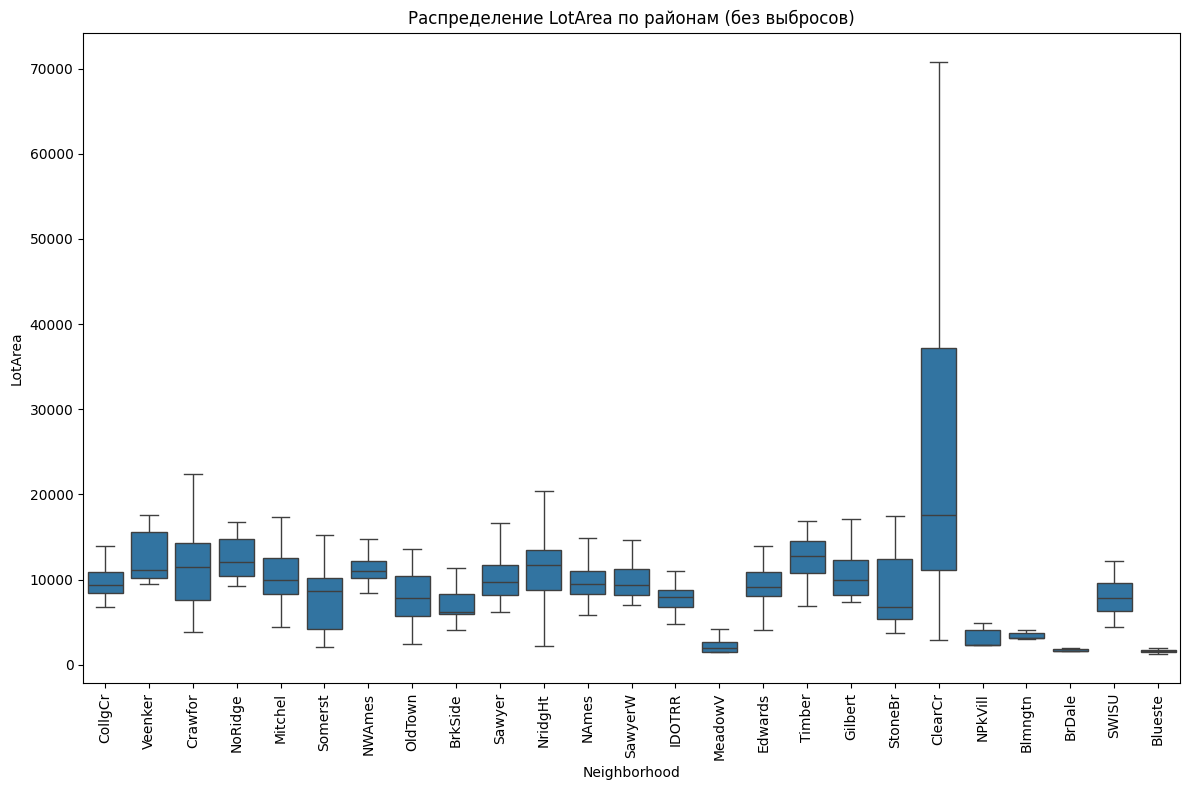

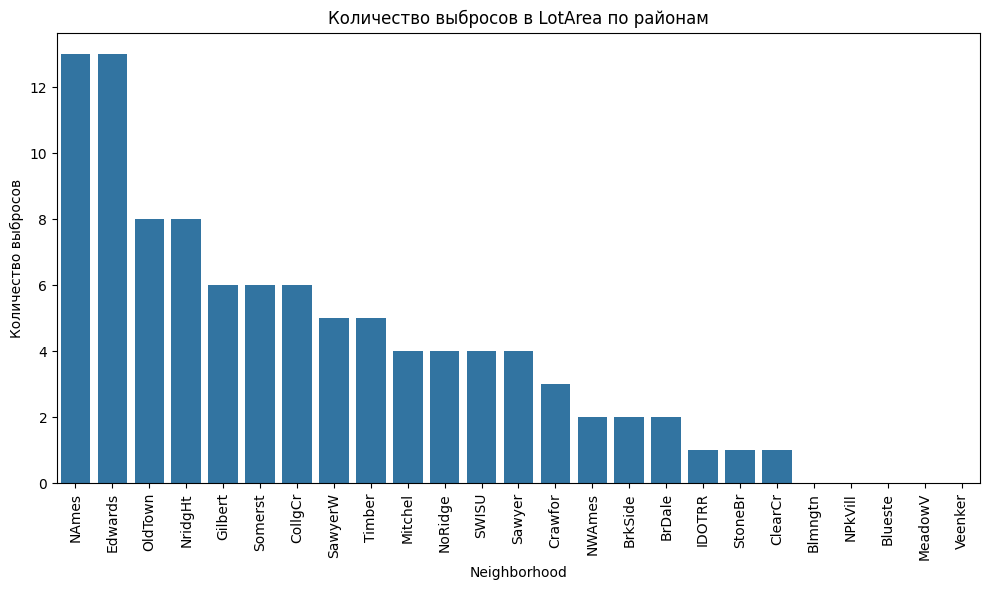

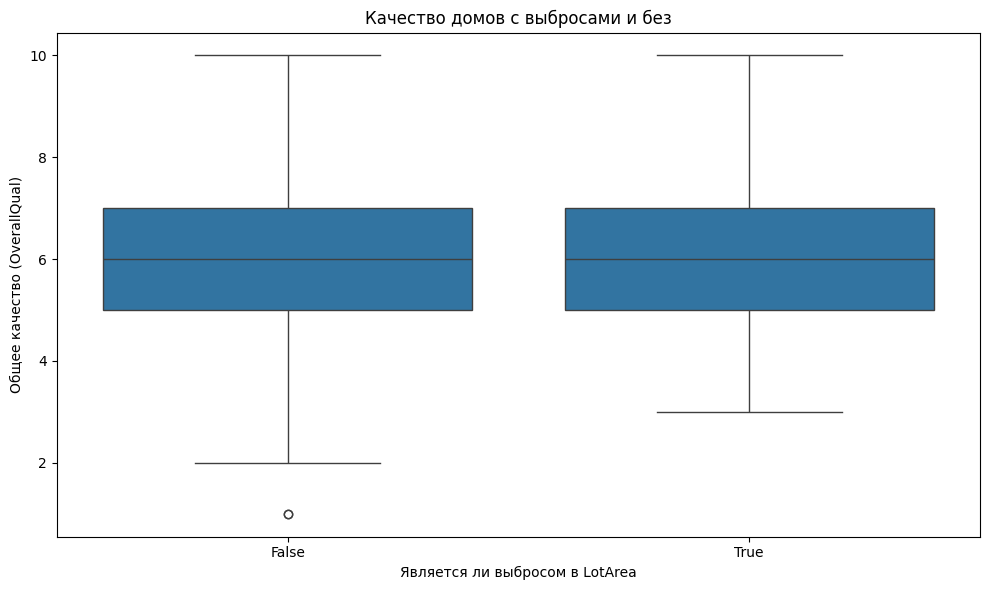


Среднее качество домов:
LotArea_outlier
False    6.093979
True     6.173469
Name: OverallQual, dtype: float64


NameError: name 'stats' is not defined

In [57]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

def detect_outliers(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (group < lower) | (group > upper)

outliers_by_neighborhood = df.groupby('Neighborhood')['LotArea'].apply(detect_outliers)
df['LotArea_outlier'] = outliers_by_neighborhood.values

outlier_counts = df.groupby('Neighborhood')['LotArea_outlier'].sum().sort_values(ascending=False)
print("Районы с наибольшим количеством выбросов:")
print(outlier_counts.head())

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Neighborhood', y='LotArea', showfliers=False)
plt.xticks(rotation=90)
plt.title('Распределение LotArea по районам (без выбросов)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.xticks(rotation=90)
plt.title('Количество выбросов в LotArea по районам')
plt.ylabel('Количество выбросов')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='LotArea_outlier', y='OverallQual')
plt.title('Качество домов с выбросами и без')
plt.xlabel('Является ли выбросом в LotArea')
plt.ylabel('Общее качество (OverallQual)')
plt.tight_layout()
plt.show()

outlier_quality = df.groupby('LotArea_outlier')['OverallQual'].mean()
print("\nСреднее качество домов:")
print(outlier_quality)

t_stat, p_value = stats.ttest_ind(
    df.loc[df['LotArea_outlier'], 'OverallQual'],
    df.loc[~df['LotArea_outlier'], 'OverallQual'],
    equal_var=False
)
print(f"\nT-тест: t={t_stat:.3f}, p={p_value:.4f}")

In [58]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'PoolQC', 'F

## Feature Engineering

Feature Engineering - это техника, с помощью которой мы создаем новые признаки, которые потенциально могут помочь в прогнозировании нашей целевой переменной, которая в данном случае является SalePrice. 

MSSubClass - это столбец с числовым признаком, который на самом деле можно представить как категориальный

In [59]:
train_df['MSSubClass'].value_counts()

MSSubClass
20     533
60     295
50     143
120     87
30      69
160     63
70      60
80      58
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

In [60]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)

In [61]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [68]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    train_df[col] = train_df[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    train_df[col] = train_df[col].map(fintype_map)

train_df['BsmtExposure'] = train_df['BsmtExposure'].map(expose_map)

Основываясь на текущих признаках, мы можем добавить первый дополнительный признак, который будет называться TotalLot и который суммирует LotFrontage и LotArea для определения общей площади земли, доступной в виде лота. Мы также можем рассчитать общее количество площади поверхности дома, TotalSF, сложив площадь от 1-го этажа и 2-го этажа. TotalBath также может быть использован, чтобы сказать нам в общей сложности, сколько ванных комнат есть в доме. Мы также можем добавить все различные типы крыльц вокруг дома и обобщить в общей площади крыльца, TotalPorch.

* TotalLot = LotFrontage + LotArea
* TotalSF = TotalBsmtSF + 2ndFlrSF
* TotalBath = FullBath + HalfBath
* TotalPorch = OpenPorchSF + EnclosedPorch + ScreenPorch
* TotalBsmtFin = BsmtFinSF1 + BsmtFinSF2

In [ ]:
train_df['TotalLot'] = train_df['LotFrontage'] + train_df['LotArea']
train_df['TotalBsmtFin'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
train_df['TotalBath'] = train_df['FullBath'] + train_df['HalfBath']
train_df['TotalPorch'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['ScreenPorch']

Иногда очень важно применить к признаку какое-то выпуклое преобразование. Например, логарифм, корень или наоборот возведение в степень.

In [69]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'PoolQC', 'F

In [70]:
train_df["LivLotRatio"] = train_df["GrLivArea"] / train_df["LotArea"]

Мы также включаем создание бинарных столбцов для некоторых признаков, которые могут указывать на наличие(1) / отсутствие(0) некоторых признаков дома

In [72]:
cols = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','WoodDeckSF','TotalPorch']

for col in cols:
    col_name = col+'_bin'
    train_df[col_name] = train_df[col].apply(lambda train_df: 1 if train_df > 0 else 0)

Наконец, поскольку нам нужны данные, которые носят численный характер, мы преобразуем оставшиеся категориальные столбцы с помощью one-hot-encoding с помощью метода get_dummies() в числовые столбцы, которые подходят для подачи в наш алгоритм машинного обучения.

In [73]:
train_df = pd.get_dummies(train_df)

In [74]:
len(train_df.columns)

238

In [75]:
train_df.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False
1,2,80.0,9600,6,8,1976,1976,0.0,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False
2,3,68.0,11250,7,5,2001,2002,162.0,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False
3,4,60.0,9550,7,5,1915,1970,0.0,NaN,NaN,...,False,False,False,True,True,False,False,False,False,False
4,5,84.0,14260,8,5,2000,2000,350.0,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False


Для создания новых признаков можно использовать обучение без учителя, например, кластеризацию с помощью k средних. Можно использовать как категорию (столбец с 0, 1, 2,...) метки кластеров или расстояние наблюдений до каждого кластера. Эти особенности иногда могут быть эффективными при распутывании сложных пространственных отношений.

In [78]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [79]:
cluster_df = cluster_labels(train_df, features=cluster_features)


In [80]:
cluster_df.head()

,Cluster
0,7
1,10
2,7
3,7
4,8


In [81]:
train_df['cluster_num'] = cluster_df["Cluster"]

## Скейлинг

Есть две основные причины, зачем нам скейлинг:
1) Многие модели учитывают масштабы для построения прогнозов
2) Многие алгоритмы сходятся быстрее для шкалированных данных.
   
Часто используются логарифмирование для данных с сильно несимметричным распределением. Логарифмирование позволяет также решить проблему нелинейности в масштабе. Основная идея в переводе мультипликативной зависимости в аддитивную.
Для последнего рассмотрим следующий пример: Для концертов с различным масштабом увеличение аудитории на константу имеет разную значимость. Рассмотрим, что происходит каждый раз, когда размер аудитории увеличивается на 50%. Для начального размера аудитории 100 происходит следующее:
$$ \log_{10}(150) = \log_{10}(100 \cdot 1.5) = \log_{10}(100) + \log_{10}(1.5) \approx 2 + 0.176 $$
Для аудитории в 1000:
$$ \log_{10}(15,000) = \log_{10}(10,000 \cdot 1.5) = \log_{10}(10,000) + \log_{10}(1.5) \approx 4 + 0.176 $$
Так мы можем уменьтшить сатурацию важности признака в зависисмости от масштаба. Важно понимать, что мы не пытаемся нормализовать переменную, а именно решить проблему скошенности.

**Задание**: Найдите такой признак в наших данных и прологарифмируйте.

Что делать, если переменная может быть отрицательной? Для этого можно использовать
$$ y = log_{base}(x + offset) $$ 
offset позволяет сдвинуть значения в нужную сторону, и лучше он должен быть меньше, чем минимальное возможное. (Если, конечно, оно известно). 

Коэффициент асимметрии до преобразования: 1.8809


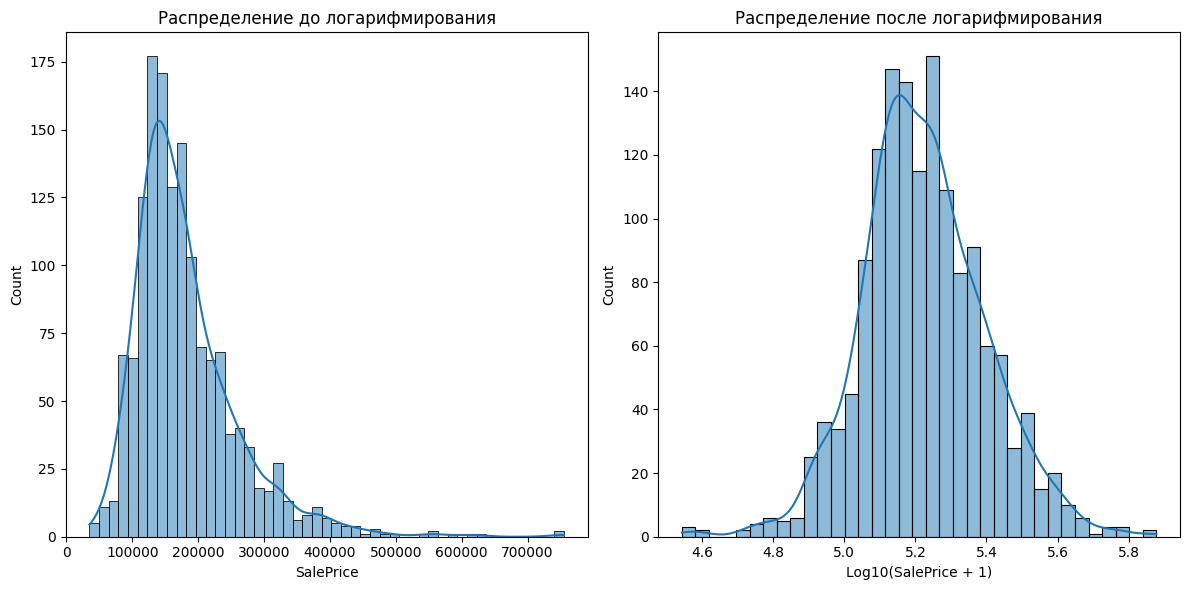

Коэффициент асимметрии после преобразования: 0.1212


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['SalePrice'], kde=True)
plt.title('Распределение до логарифмирования')
plt.xlabel('SalePrice')

skewness = stats.skew(df['SalePrice'].dropna())
print(f"Коэффициент асимметрии до преобразования: {skewness:.4f}")

df['Log_SalePrice'] = np.log10(df['SalePrice'] + 1)

plt.subplot(1, 2, 2)
sns.histplot(df['Log_SalePrice'], kde=True)
plt.title('Распределение после логарифмирования')
plt.xlabel('Log10(SalePrice + 1)')
plt.tight_layout()
plt.show()

log_skewness = stats.skew(df['Log_SalePrice'].dropna())
print(f"Коэффициент асимметрии после преобразования: {log_skewness:.4f}")

Это не универсальное решение. Хотя оно может улучшать распределения с перекосом вправо (где большинство точек данных имеют более низкие значения), он оказывает противоположный эффект на распределение, которое не искажено или смещено влево.

Есть ли альтернативы? Итак, нам нужен метод, который преобразует шкалу в неперекошенную, а также работает с отрицательными данными. 

Квадратный корень может быть тем, что мы ищем. Сам по себе он принимает на вход положительное число и возвращает число, которое при умножении на себя равно входному значению. Это дает желаемый эффект сжатия: большие значения сжимаются сильнее, чем меньшие. Кроме того, поскольку его областью определения являются положительные числа (0 — это особый случай, поскольку он отображается сам в себя), мы можем отразить его, чтобы работать с отрицательными числами так же, как он работал с положительными числами. Это приводит к следующему преобразованию:
$$ y = \text{sign}(x)\sqrt{\left| x \right|} $$

У него нет такой возможности сжимать большие значения, как у логарифмов, но зато оно будет легко работать с отрицательными значениями и позволит  уловить квадратичные эффекты. Однако, хотя оно сохраняет порядок числовых значений, но не дает нам хорошего способа интерпретировать изменения (и может исказить неискаженные распределения).

### Скейлинг с обучением
RobustScaler - это метод преобразования, который удаляет медиану и масштабирует данные в соответствии с диапазоном квантиля (по умолчанию IQR: межквартильный диапазон). IQR - это диапазон между 1-м квартилем (25-й квантилем) и 3 Квартиль (75-й квантиль). Он также устойчив к пропускам, что делает его идеальным для данных, где слишком много пропусков, что резко сокращает количество обучающих данных.

Запуская скейлер как на тренировочном, так и на тестовом наборах, мы подвергаем себя проблеме утечки данных. Утечка данных - это проблема, когда для создания модели используется информация извне набора для обучения. Если мы подгоняем скейлер как на тренировочные, так и на тестовые данные, наши характеристики тренировочных данных будут содержать распределение нашего тестового набора. Таким образом, мы неявно передаем информацию о наших тестовых данных в окончательные тренировочные данные для обучения, что не даст нам возможности по-настоящему протестировать нашу модель на данных, которые она никогда не видела.

*Извлеченные уроки:* Установка скейлера только на обучающие данные, а затем преобразование данных как обучающей, так и тестовой выборок

In [86]:
from sklearn.preprocessing import RobustScaler

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

train_df = train_df.drop(["Id"], axis=1)

cols = train_df.select_dtypes(np.number).columns

train_df_scaled = train_df.copy()

transformer = RobustScaler().fit(train_df_scaled[cols])
train_df_scaled[cols] = transformer.transform(train_df_scaled[cols])

print("Пример преобразованных данных:")
print(train_df_scaled[cols].head())

Пример преобразованных данных:
   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0         0.2    -0.190476 -0.254076          0.5          0.0   0.652174   
1        -0.6     0.523810  0.030015          0.0          3.0   0.065217   
2         0.2    -0.047619  0.437624          0.5          0.0   0.608696   
3         0.4    -0.428571  0.017663          0.5          0.0  -1.260870   
4         0.2     0.714286  1.181201          1.0          0.0   0.586957   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  WoodDeckSF  \
0      0.243243    1.180723    0.452790         0.0  ...    0.000000   
1     -0.486486    0.000000    0.834679         0.0  ...    1.773810   
2      0.216216    0.975904    0.143910         0.0  ...    0.000000   
3     -0.648649    0.000000   -0.235170         0.0  ...    0.000000   
4      0.162162    2.108434    0.381186         0.0  ...    1.142857   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal 

Таким образом, мы сильно преобразовали наш обучающий набор. Кроме перчисленного, полезно использовать PCA, выбор признаков на основе информации и други методы. Как вы, наверное, заметили, все преобразования были сделаны только для тренировочного набора, но то же самое необходимо сделать и для тестового.

Чтобы предотвратить утечку данных, все преобразования по среднему и тп нужно сделать независимо, а если мы, например, кодировали или удаляли столбцы, нужно сделать такое же преобразование, используя старые правила. 

После того, как это было сделано, можно передавать данные в модель.

**Задание**: Используя признаки, построенные для обучающего набора, дополните тестовый. Сохраните результирующие наборы на будущее.

In [89]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import joblib

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv',
        'test_dataset': 'kaggle_house_prices.tar/test.csv'
    }
}

train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])
test_ids = test_df['Id']

train_df = train_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

target_col = 'SalePrice'
if target_col in train_df.columns:
    y_train = train_df[target_col]
    train_df = train_df.drop(target_col, axis=1)
    test_has_target = target_col in test_df.columns
    if test_has_target:
        y_test = test_df[target_col]
        test_df = test_df.drop(target_col, axis=1)

num_cols = train_df.select_dtypes(include=np.number).columns
cat_cols = train_df.select_dtypes(exclude=np.number).columns

num_imputer = SimpleImputer(strategy='median')
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = num_imputer.transform(test_df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

for df in [train_df, test_df]:
    df['Log_LotArea'] = np.log10(df['LotArea'] + 1)

num_cols = train_df.select_dtypes(include=np.number).columns

scaler = RobustScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

joblib.dump(num_imputer, 'num_imputer.pkl')
joblib.dump(cat_imputer, 'cat_imputer.pkl')
joblib.dump(scaler, 'robust_scaler.pkl')

train_df.to_csv('preprocessed_train.csv', index=False)
test_df.to_csv('preprocessed_test.csv', index=False)
test_ids.to_csv('test_ids.csv', index=False)

## Кластеринг